# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
import string
from collections import Counter
from nltk.tokenize import word_tokenize


class TextPreprocessor:
    @staticmethod
    def preprocess_text(text):
        return text.lower().translate(str.maketrans('', '', string.punctuation))




def count_words(texts):
    return Counter(
        word
        for text in texts
        for word in word_tokenize(TextPreprocessor.preprocess_text(text))
    )



def create_vocab(word_counts, counter_threshold=25):
    return {'<unk>', '<bos>', '<eos>', '<pad>'} | {
        word for word, count in word_counts.items() if count > counter_threshold
    }


def create_word_indices(vocab):
    word2ind = {word: i for i, word in enumerate(vocab)}
    ind2word = {i: word for word, i in word2ind.items()}
    return word2ind, ind2word


# Шаг 1: Подсчет слов
word_counts = count_words(tqdm(dataset['train']['text']))

# Шаг 2: Создание словаря
vocab = create_vocab(word_counts)

# Шаг 3: Создание индексов
word2ind, ind2word = create_word_indices(vocab)

print(f'Размер словаря: {len(vocab)}')
print(word2ind)

100%|██████████| 120000/120000 [00:24<00:00, 4864.00it/s]

Размер словаря: 11842
{'indoors': 0, 'homecoming': 1, 'undefeated': 2, 'tone': 3, 'environmental': 4, 'medicines': 5, 'shaukat': 6, 'married': 7, 'consistent': 8, 'antidepressants': 9, 'ready': 10, 'chassis': 11, 'martha': 12, 'pulls': 13, 'devastated': 14, 'laura': 15, 'cds': 16, 'brazil': 17, 'peace': 18, 'packed': 19, 'scrutiny': 20, 'reflect': 21, 'beautiful': 22, 'format': 23, 'freeagent': 24, 'quick': 25, 'documents': 26, 'pat': 27, 'proper': 28, 'mozilla': 29, 'heavily': 30, 'enforcement': 31, 'introducing': 32, 'thomas': 33, 'riyadh': 34, 'unusually': 35, 'oval': 36, 'deployment': 37, 'belonging': 38, 'preserved': 39, 'few': 40, 'exploded': 41, 'encounter': 42, 'scramjet': 43, 'compared': 44, 'faithful': 45, 'den': 46, 'fancy': 47, 'g20': 48, 'drag': 49, 'crimson': 50, 'kill': 51, '600000': 52, 'influenza': 53, 'activity': 54, 'overcome': 55, 'sluman': 56, 'quit': 57, 'cloud': 58, 'postseason': 59, 'disappearance': 60, 'marlins': 61, 'undergoes': 62, 'leaked': 63, 'skate': 64, 

In [ ]:
class TextTokenizer:
    def __init__(self, word2ind):
        self.word2ind = word2ind
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def tokenize(self, text):
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [self.word2ind.get(word, self.unk_id) for word in word_tokenize(text)]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence


class WordDataset:
    def __init__(self, sentences, word2ind):
        self.data = sentences
        self.preprocessor = TextPreprocessor()
        self.tokenizer = TextTokenizer(word2ind)

    def __getitem__(self, idx):
        text = self.preprocessor.preprocess_text(self.data[idx]['text'])
        tokenized_sentence = self.tokenizer.tokenize(text)
        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }
        return train_sample

    def __len__(self):
        return len(self.data)


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from typing import List, Dict


class DataLoaderDecorator:
    def __init__(self, dataset, word2ind, device='cpu'):
        self.dataset = dataset
        self.word2ind = word2ind
        self.pad_id = word2ind['<pad>']
        self.device = device

    def select_random_subset(self, size):
        if size > len(self.dataset):
            raise ValueError("Size larger than dataset")

        idx = np.random.choice(np.arange(len(self.dataset)), size, replace=False)
        idx = [int(i) for i in idx]
        subset = [self.dataset[i] for i in idx]
        return type(self)(subset, self.word2ind, self.device)

    @staticmethod
    def trim_sequences(input_batch: List[Dict[str, List[int]]], max_len=256) -> List[Dict[str, List[int]]]:
        return list(map(lambda sequence: {'text': sequence['text'][:max_len], 'label': sequence['label']}, input_batch))

    @staticmethod
    def pad_sequences(input_batch: List[Dict[str, List[int]]], pad_id, max_len=256) -> List[List[int]]:
        def pad_sequence(sequence: List[int]) -> List[int]:
            return sequence + [pad_id] * (max_len - len(sequence))
        return [pad_sequence(sequence['text']) for sequence in input_batch]

    @staticmethod
    def create_tensors(padded_sequences: List[List[int]], input_batch: List[Dict[str, int]], device) -> Dict[str, torch.Tensor]:
        sequences_tensor = torch.LongTensor(padded_sequences).to(device)
        labels_tensor = torch.LongTensor([x['label'] for x in input_batch]).to(device)
        return {'input_ids': sequences_tensor, 'label': labels_tensor}

    def collate_fn_with_padding(self, input_batch: List[Dict[str, List[int]]], max_len=256) -> Dict[str, torch.Tensor]:
        #print("pad_id:", self.pad_id)  # Проверка pad_id
        #print("input_batch before processing:", input_batch)

        max_seq_len = min(max([len(x['text']) for x in input_batch]), max_len)

        input_batch = self.trim_sequences(input_batch, max_seq_len)
        #print("input_batch after trimming:", input_batch)  # После обрезки
        padded_sequences = self.pad_sequences(input_batch, self.pad_id, max_seq_len)
        #print("padded_sequences:", padded_sequences)  # После дополнения
        batch_tensors = self.create_tensors(padded_sequences, input_batch, self.device)
        #print("batch_tensors:", batch_tensors)  # Результаты в тензорах

        return batch_tensors

    def create_dataloader(self, batch_size=32, shuffle=True, max_len=256):
        return DataLoader(
            self.dataset,
            shuffle=shuffle,
            batch_size=batch_size,
            collate_fn=lambda x: self.collate_fn_with_padding(x, max_len=max_len)
        )


In [ ]:
train_dataset = WordDataset(dataset['train'], word2ind)
test_dataset = WordDataset(dataset['test'], word2ind)


train_prep = DataLoaderDecorator(train_dataset, word2ind, device)
eval_prep = DataLoaderDecorator(test_dataset, word2ind, device)
random_eval_prep = eval_prep.select_random_subset(5000)

train_dataloader = train_prep.create_dataloader(batch_size=64, shuffle=True)
eval_dataloader = random_eval_prep.create_dataloader(batch_size=64, shuffle=False)

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Запуск базовой модели с семинара на новом датасете


In [ ]:
import torch
import torch.nn as nn

class Aggregator(nn.Module):
    def forward(self, outputs):
        raise NotImplementedError("Aggregator must implement the forward method")

class MaxAggregator(Aggregator):
    def forward(self, outputs):
        return outputs.max(dim=1)[0]

class MeanAggregator(Aggregator):
    def forward(self, outputs):
        return outputs.mean(dim=1)

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_value: float,
        num_classes: int = 4,
        aggregator: Aggregator = MaxAggregator()
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_value)

        self.aggregator = aggregator

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregator(output)

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction


def choose_aggregator(aggregation_type: str) -> Aggregator:
  if aggregation_type == 'max':
      return MaxAggregator()
  elif aggregation_type == 'mean':
      return MeanAggregator()
  else:
      raise ValueError(f"Unsupported aggregation type: {aggregation_type}")

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            targets.append(batch['label'])

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    accuracy = (predictions == targets).float().mean().item()

    return accuracy

In [ ]:
import torch
from tqdm import tqdm
from functools import reduce



def batch_step(model, batch, criterion, optimizer, device):
    optimizer.zero_grad()
    input_ids, labels = batch['input_ids'].to(device), batch['label'].to(device)
    logits = model(input_ids)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    return loss.item()


def epoch_training(model, train_dataloader, criterion, optimizer, device, eval_steps, eval_dataloader):
    model.train()

    # Используем map для применения функции к каждому элементу данных
    losses = list(map(lambda batch: batch_step(model, batch, criterion, optimizer, device), train_dataloader))

    # Рассчитываем средний loss для эпохи
    epoch_loss = sum(losses) / len(losses)

    # Вычисляем точность каждые eval_steps шагов
    accuracy = [evaluate(model, eval_dataloader) for i, _ in enumerate(losses) if (i+1) % eval_steps == 0]

    return epoch_loss, accuracy


def train(model, train_dataloader, criterion, optimizer, device, num_epochs, eval_steps, eval_dataloader):
    # Используем reduce для аккумуляции результатов обучения
    results = reduce(lambda acc, _: acc + [epoch_training(model, train_dataloader, criterion, optimizer, device, eval_steps, eval_dataloader)],
                     range(num_epochs), [])

    # Разделяем результаты на losses и accuracies
    losses, acc = zip(*results)
    return list(losses), list(acc)


def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Используем map для применения модели ко всем батчам в DataLoader
        logits_and_targets = map(lambda batch: (model(batch['input_ids']).argmax(dim=1), batch['label']), eval_dataloader)

        # Разделяем кортежи на два списка с помощью zip
        logits, targets = zip(*logits_and_targets)

        # Используем torch.cat для объединения результатов в один тензор
        predictions = torch.cat(logits)
        targets = torch.cat(targets)

        # Вычисляем точность
        accuracy = (predictions == targets).float().mean().item()

    return accuracy


def run_training_sessions(model, train_dataloader, eval_dataloader, device, num_epochs, eval_steps):
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    aggregation_types = ['max', 'mean']

    # Функция для выполнения тренировки и оценки модели
    def train_and_evaluate(aggregation_type):
        print(f"Starting training for {aggregation_type}")
        model.aggregator = choose_aggregator(aggregation_type)
        model.to(device)

        pbar = tqdm(total=num_epochs, desc=f"Aggregation: {aggregation_type}", leave=True)
        losses, acc = train(model, train_dataloader, criterion, optimizer, device, num_epochs, eval_steps, eval_dataloader)
        pbar.close()

        return aggregation_type, {
            'losses': losses,
            'accuracy': acc
        }

    # Использование map для применения функции train_and_evaluate к каждому элементу в aggregation_types
    results = dict(map(train_and_evaluate, aggregation_types))

    return results

In [ ]:
def train(model, train_dataloader, criterion, optimizer, device, num_epochs, eval_steps, eval_dataloader):
    losses = []
    acc = []

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            input_ids, labels = batch['input_ids'].to(device), batch['label'].to(device)
            logits = model(input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0 and i != 0:
                accuracy = evaluate(model, eval_dataloader)
                acc.append(accuracy)
                model.train()  # Ensure model is back in training mode

        epoch_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(epoch_loss)

    return losses, acc

def run_training_sessions(model, train_dataloader, eval_dataloader, device, num_epochs, eval_steps):
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    aggregation_types = ['max', 'mean']
    results = {}

    for aggregation_type in aggregation_types:
        print(f"Starting training for {aggregation_type}")
        model.aggregator = choose_aggregator(aggregation_type)
        model.to(device)

        losses, acc = train(model, train_dataloader, criterion, optimizer, device, num_epochs, eval_steps, eval_dataloader)

        results[aggregation_type] = {
            'losses': losses,
            'accuracy': acc
        }

    return results

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CharLM(hidden_dim=256, vocab_size=len(vocab), dropout_value=0.1).to(device)
num_epochs = 5
eval_steps = len(train_dataloader) // 2

# Запуск сессий обучения
results = run_training_sessions(model, train_dataloader, eval_dataloader, device, num_epochs, eval_steps)
print(results)

Starting training for max




Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 4/1875 [00:00<00:54, 34.18it/s]

Training epoch 0::   0%|          | 8/1875 [00:00<00:56, 33.12it/s]

Training epoch 0::   1%|          | 12/1875 [00:00<00:57, 32.22it/s]

Training epoch 0::   1%|          | 16/1875 [00:00<00:57, 32.27it/s]

Training epoch 0::   1%|          | 20/1875 [00:00<00:58, 31.89it/s]

Training epoch 0::   1%|▏         | 24/1875 [00:00<00:58, 31.44it/s]

Training epoch 0::   1%|▏         | 28/1875 [00:00<00:58, 31.58it/s]

Training epoch 0::   2%|▏         | 32/1875 [00:01<00:59, 31.18it/s]

Training epoch 0::   2%|▏         | 36/1875 [00:01<00:57, 31.76it/s]

Training epoch 0::   2%|▏         | 40/1875 [00:01<00:56, 32.55it/s]

Training epoch 0::   2%|▏         | 44/1875 [00:01<00:58, 31.45it/s]

Training epoch 0::   3%|▎         | 48/1875 [00:01<00:56, 32.10it/s]

Training epoch 0::   3%|▎         | 52/1875 [00:01<00:58, 31.26it/s]

Training epoch 0::   3%|▎    

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


class LossesPlotter():
    def plot(self, losses_type, colors):
        for (name, values), color in zip(losses_type.items(), colors):
            plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)
        plt.title('Losses')
        plt.xlabel("epoch")
        plt.legend()
        plt.show()


class AccuracyPlotter():
    def plot(self, acc_type, colors):
        for (name, values), color in zip(acc_type.items(), colors):
            plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
            print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")
        plt.title('Accuracy')
        plt.xlabel("epoch")
        plt.legend()
        plt.show()



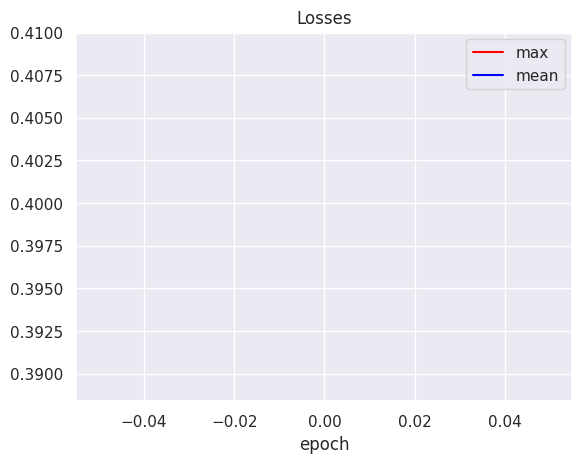

Лучшая accuracy для подхода max: 88.62
Лучшая accuracy для подхода mean: 87.20


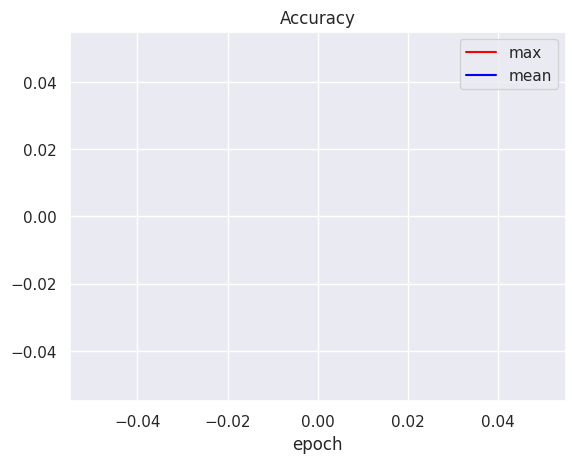

In [ ]:
losses_plotter = LossesPlotter()
accuracy_plotter = AccuracyPlotter()

# Подготовка данных для графиков
losses_type = {'max': results['max']['losses'], 'mean': results['mean']['losses']}
acc_type = {'max': results['max']['accuracy'], 'mean': results['mean']['accuracy']}

# Построение графиков
losses_plotter.plot(losses_type, ['red', 'blue'])
accuracy_plotter.plot(acc_type, ['red', 'blue'])




### Проведение экспериментов по улучшению модели
* Эксперимент 1: увеличение dropout до 0.5



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CharLM(hidden_dim=256, vocab_size=len(vocab), dropout_value=0.5).to(device)
num_epochs = 5
eval_steps = len(train_dataloader) // 2

# Запуск сессий обучения
results = run_training_sessions(model, train_dataloader, eval_dataloader, device, num_epochs, eval_steps)

In [ ]:
losses_plotter = LossesPlotter()
accuracy_plotter = AccuracyPlotter()

# Подготовка данных для графиков
losses_type = {'max': results['max']['losses'], 'mean': results['mean']['losses']}
acc_type = {'max': results['max']['accuracy'], 'mean': results['mean']['accuracy']}

# Построение графиков
losses_plotter.plot(losses_type, ['red', 'blue'])
accuracy_plotter.plot(acc_type, ['red', 'blue'])

Эксперимент 2: изменение архитектуры, dropout: 0.5

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_value: float,
        num_classes: int = 4,
        aggregator: Aggregator = MaxAggregator()
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_value)

        self.aggregator = aggregator

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregator(output)

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction